In [1]:
#only (patient_id%NR_SHARDS) == SHARD_ID will be processed here
#choose a value between 1-NR_SHARDS
SHARD_ID = 1
IMAGE_W = 224
IMAGE_H = 152
IMAGE_D = 224
# IMAGE_W = 50
# IMAGE_H = 34
# IMAGE_D = 50

NR_SHARDS = 1
RANDOM_SEED = 0.1

#Patient DICOM images folder
# INPUT_FOLDER = 'output/'
INPUT_FOLDER = '../../input/sample_images/'
OUTPUT_FOLDER = '../../output/step3/' + str(SHARD_ID) + '/'
LABELS_FILE = '../../input/sample_labels.csv'
# LABELS_FILE = 'sample_labels-output.csv'

In [2]:
# %matplotlib inline
# %pylab inline
# plt.ion()

import csv
import h5py
from random import shuffle
import numpy as np # linear algebra
from numpy import ndarray
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statistics
import csv
import dicom
import math
from time import time
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
import itertools
from itertools import product, combinations
from skimage import measure, morphology, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
    
    def start(self):
        self._start = time()
        if(self._debug):
            log('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            log('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)
        
import datetime
def log(message):
    print('{} {}'.format(datetime.datetime.now(), message))


In [4]:
def show_image(pixels, slice_pos):
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(4,4)
    ax1.imshow(pixels[round(np.shape(pixels)[0]*(slice_pos-1))], cmap=plt.cm.gray)
    plt.show()


In [5]:
def show_slices(pixels, nr_slices=12, cols=4):
    fig = plt.figure()
    slice_depth = round(np.shape(pixels)[0]/nr_slices)
    rows = round(nr_slices/cols)+1
    fig.set_size_inches(cols*10, rows*10)
    for i in range(nr_slices):
        slice_pos = int(slice_depth*i)
        y = fig.add_subplot(rows,cols,i+1)
        y.imshow(pixels[slice_pos], cmap='gray')
    plt.show()


In [6]:
# Load the scans in given folder path
#image pixels dimensions: z, y, x
def load_scan(path):
    t = Timer('load_scan ' + path)
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.slice_thickness = slice_thickness

    t.stop()
    return slices

#image pixels dimensions: z, y, x
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

#image pixels dimensions: z, y, x
def resample(image, scan, new_spacing=[1,1,1]):
    t = Timer('resample')
    # Determine current pixel spacing
    spacing = np.array([scan[0].slice_thickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    t.stop()
    
    return image, new_spacing

def largest_label_volume(im, bgs=[]):
    vals, counts = np.unique(im, return_counts=True)
    for bg in bgs:
        counts = counts[vals != bg]
        vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    t = Timer('segment_lung_mask')

#     show_slices(image)
    
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    
    #avoid small holes between lung and external body due to cropped scans
    print('1')
#     binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, 2)
    
    #cleanup some small bubbles inside body before labelling
    print('2')
    binary_image = scipy.ndimage.morphology.grey_closing(binary_image, 3)
#     show_slices(binary_image)

    labels = measure.label(binary_image)
#     show_slices(labels)
    
    #discover lung label number by looking at the middle lung slice
    #look inside the volume where lung structures is meant to be
#     lung_label = largest_label_volume(labels[s[0]*0.2:s[0]*0.8, s[1]*0.25:s[1]*0.75, s[2]*0.25:s[2]*0.75], bg=0)
#     air1 = labels[0,0,0]
#     air2 = labels[0,np.shape(labels)[1]-1,0]
    air1 = 0
    air2 = 0
    s = np.array(np.shape(labels))
    body = largest_label_volume(labels[round(s[0]*0.6):round(s[0]*0.64), round(s[1]*0.47):round(s[1]*0.53), 0:s[2]*0.12], bgs=[0, air1, air2])
    bgs = [0, air1, air2, body]
    print('bgs',bgs)

    lung_label = largest_label_volume(labels[s[0]*0.2:s[0]*0.8, s[1]*0.25:s[1]*0.75, s[2]*0.25:s[2]*0.75], bgs=bgs)

    #TEMP
#     lung_label = largest_label_volume(labels[round(s[0]*0.6), round(s[1]*0.5)], bgs=[0, air1, air2])

    print('lung_label',lung_label)

    #remove everything that is not part of the lung
    print('remove non lung structures')
    binary_image[labels != lung_label] = 2
#     show_slices(binary_image)
    
    #Determine which label clusters refers to the air/space around the person body and turn it into the same cluster
    #The various corners are measured in case of volume being broken when the body is not fitted inside scan
#     print('3')
#     si = np.shape(binary_image)
#     si0 = si[0]-3
#     si1 = si[1]-3
#     si2 = si[2]-3
#     for i in (2, si0):
#         for j in (2, si1):
#             for k in (2, si2):
#                 if(labels[i,j,k] != lung_label):
#                     binary_image[labels[i,j,k] == labels] = 2

    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bgs=[0])
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    print('fill_lung_structures')
#     show_slices(binary_image)
    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
#     labels = measure.label(binary_image, background=0)
    
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None: # There are air pockets
#         binary_image[labels != l_max] = 0

    #dilate mask
    binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, size=(10,10,10))
    t.stop()
    
    show_slices(binary_image)
    
    return binary_image

#returns ((x1, y1, z1), (x2, y2, z2))
def bounding_box(img):
    N = img.ndim
    out = []
    for ax in itertools.combinations(range(N), N - 1):
        nonzero = np.any(img, axis=ax)
#         if(np.amin(nonzero)==0):
#             return None
        out.extend(np.where(nonzero)[0][[0, -1]])
    r = np.reshape(np.asarray(tuple(out)), (-1, 2)).T
    return [tuple(r[0]), tuple(r[1])]

#return bounding box center in (x,y,z)
def bounding_box_center(bounds):
    return (int(round((bounds[0][0] + (bounds[1][0]-bounds[0][0])/2))), int(round((bounds[0][1] + (bounds[1][1]-bounds[0][1])/2))), int(round((bounds[0][2] + (bounds[1][2]-bounds[0][2])/2))))


In [7]:
#find lungs rotation by finding minimum and maximum extremities from lung halves
def find_minmax_halfx(lung_mask, xhalf, bottom2up=True, left2right=True, slicen=220):
    xsize = np.shape(lung_mask)[2]-1
    ysize = np.shape(lung_mask)[1]-1
    im = np.swapaxes(lung_mask[slicen], 0, 1)

    if(bottom2up): mvalue = (-1,0)
    else: mvalue = (-1, ysize)
        
    if(left2right): 
        xstart = 0
        xend = xhalf
        xdir = 1
    else:
        xstart = xsize
        xend = xhalf
        xdir = -1
        
    for x in range(xstart, xend, xdir):
        for y in range(ysize):
            if(not bottom2up): yi = ysize - y
            else: yi = y

            if(im[x][yi]>0.5):
                if(bottom2up and yi>mvalue[1]):
                    mvalue = (x, yi)
                elif(not bottom2up and yi<mvalue[1]):
                    mvalue = (x, yi)
    return mvalue
    
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0]))

def value_between(value, min_value, max_value):
    if(value<min_value): return False
    if(value>max_value): return False
    return True

def discover_lung_rotation(lung_mask):
    bbox = bounding_box(lung_mask)
    if(bbox == None): return 0
    slicen = int((bbox[1][2]-bbox[0][2])/2)
    half = int(bbox[0][0]+(bbox[1][0]-bbox[0][0])/2)

    l1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=True, slicen=slicen)
    r1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=False, slicen=slicen)
    l2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=True, slicen=slicen)
    r2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=False, slicen=slicen)

    r = (l1, r1, l2, r2)
    xs, ys = zip(*r)
    
    #verify points sanity
    if(not value_between(xs[1]-xs[0], 50, 200) or
       not value_between(xs[3]-xs[2], 50, 200) or
       not value_between(ys[0]-ys[2], 100, 250) or
       not value_between(ys[1]-ys[3], 100, 250)):
        print('Strange rotation detected. returning 0 degrees')
        return 0
    
    angle1 = calculate_angle(l1, r1)
    angle2 = calculate_angle(l2, r2)
    
#     fig1, ax1 = plt.subplots(1)
#     fig1.set_size_inches(2,2)
#     ax1.imshow(lung_mask[slicen], cmap=plt.cm.gray)
#     ax1.scatter(xs, ys)
#     plt.show()
    
    a = ((angle1 + angle2)/2)
    return min(max(a, -10), 10)

In [8]:
def get_patient_ids(shard_id, input_dir):
    shard_patients = []
    
    file = csv.DictReader(open(LABELS_FILE))    
    for row in file:
        p = row['id']
        if(int(p,16)%NR_SHARDS == (shard_id-1)):
            shard_patients.append(p)
    log('found {} patients for shard {}'.format(len(shard_patients), shard_id))
    shuffle(shard_patients, lambda: RANDOM_SEED)
    return shard_patients

In [9]:
def generate_slice(patient_px, patient_id, slice_pos, output_dir):
    t = Timer('generate_slice ' + str(slice_pos))
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(6,6)
    ax1.imshow(patient_px[slice_pos], cmap=plt.cm.gray)
    file = output_dir + patient_id + '-' + 'slice-' + str(slice_pos) + '.jpg'
    plt.savefig(file)
        
#     plt.close(fig1)
    plt.show()
    t.stop()

In [10]:
def process_patient_label(input_dir, patient_id, output_dataset, dataset_row):
    labels = pd.read_csv(LABELS_FILE, index_col=0)
    value = labels.get_value(patient_id, 'cancer')
    #one-hot encoding
    label = np.array([0,1])
    if(value == 0): label = np.array([1,0])
    output_dataset[dataset_row] = label

In [11]:
def diff_for_shiffiting(point1, point2):
    t = np.subtract(point1, point2)
    return (t[2], t[1], t[0])

In [12]:
def bbox_dim(bbox):
    bw = bbox[1][0]-bbox[0][0]
    bh = bbox[1][1]-bbox[0][1]
    bd = bbox[1][2]-bbox[0][2]
    return bw,bh,bd

In [13]:
def process_patient_images(input_dir, patient_id, image_w, image_h, image_d, output_dataset, dataset_row, output_dir):
    patient_dir = input_dir + patient_id
    patient_scan = load_scan(patient_dir)
    patient_pixels = get_pixels_hu(patient_scan)
    show_image(patient_pixels, 0.5)
    patient_pixels, spacing = resample(patient_pixels, patient_scan, [1,1,1])
#     show_image(patient_pixels, 0.5)
    patient_lung_mask = segment_lung_mask(patient_pixels, True)
    show_image(patient_lung_mask, 0.5)
    
    t = Timer('apply lung mask to image volume')
    patient_pixels = np.ma.masked_where(patient_lung_mask==0, patient_pixels).filled(fill_value=0)
    t.stop()

    t = Timer('rotate image for optimal pose')
    rotation_angle = discover_lung_rotation(patient_lung_mask)
    patient_pixels = rotate(patient_pixels,rotation_angle,(1,2), reshape=False)
    t.stop()
    
    t = Timer('resize image volume to {}x{}x{}'.format(image_w, image_h, image_d))
    bbox = bounding_box(patient_lung_mask)
    if(bbox == None):
        return False
    bw,bh,bd = bbox_dim(bbox)
    fit_volume = (image_w, image_h, image_d)
    ratio = min(tuple(np.divide(fit_volume,np.subtract(bbox[1],bbox[0]))))
    print('ratio=', ratio)
   
    patient_pixels = scipy.ndimage.interpolation.zoom(patient_pixels[bbox[0][2]:bbox[1][2],bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]], ratio)
    t.stop()

    t = Timer('translate to center')
    fit_volume_center = tuple(np.divide(fit_volume, 2))
    bbox = bounding_box(patient_pixels)
    bbox_center = bounding_box_center(bbox)

    patient_pixels2 = np.full((image_d, image_h, image_w),0)
    ps = np.shape(patient_pixels)
    patient_pixels2[:ps[0],:ps[1],:ps[2]] = patient_pixels[:ps[0],:ps[1],:ps[2]]
    patient_pixels = patient_pixels2
    
    diff = (np.subtract(fit_volume_center,bbox_center))
    patient_pixels = shift(patient_pixels, (diff[2],diff[1],diff[0]))
    t.stop()

    #normalization for better training on neural networks
    t = Timer('pixel normalization')
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    
    patient_pixels = (patient_pixels - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    patient_pixels[patient_pixels>1] = 1.
    patient_pixels[patient_pixels<0] = 0.

    #0-center pixels
    print('mean pixels=',np.mean(patient_pixels))
    PIXEL_MEAN = 0.6 #calculated before
    patient_pixels = patient_pixels - PIXEL_MEAN
    t.stop()
    
    generate_slice(patient_pixels, patient_id, round(np.shape(patient_pixels)[0]/2), output_dir)

    t = Timer('put patient image into dataset')
    output_dataset[dataset_row] = patient_pixels
    t.stop()
    
    return True

In [ ]:
def start_processing(input_dir, shard_id, max_patients, image_w, image_h, image_d, output_dir):
    log('Processing patients. shard_id=' + str(shard_id) + ' max_patients='+ str(max_patients) + ' input_dir=' + input_dir + ' output_dir=' + output_dir)
    
    log('Gathering patient ids for this shard')
    patient_ids = get_patient_ids(shard_id, input_dir)
    total_patients = len(patient_ids)
    
    log('Preparing output dir')
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir)
    except:
        print('Ops! Couldnt create output dir')
        pass
    
    log('Creating datasets')
    dataset_file = output_dir + 'data-centered-rotated-{}-{}-{}.h5'.format(image_w, image_h, image_d)
    h5f = h5py.File(dataset_file, 'w')
    x_ds = h5f.create_dataset('X', (total_patients, image_d, image_h, image_w), chunks=(1, image_d, image_h, image_w), dtype='f')
    y_ds = h5f.create_dataset('Y', (total_patients, 2), dtype='f')

    log('Starting to process each patient (count={})'.format(len(patient_ids)))
    count = 0
    record_row = 0

    for patient_id in patient_ids:
        if(count>(max_patients-1)):
            break

        t = Timer('>>> PATIENT PROCESSING ' + patient_id + ' (count=' + str(count) + '; output_dir=' + output_dir + ')')
        try:
            r = process_patient_images(input_dir, patient_id, image_w, image_h, image_d, x_ds, record_row, output_dir)
            if(r):
                process_patient_label(input_dir, patient_id, y_ds, record_row)
                record_row = record_row + 1
            else:
                print('Patient lung not found. Skipping.')   
            t.stop()
        except:
            print('!!!! There was a problem processing patient_id=', patient_id)
            pass
        
        count = count + 1
        
    h5f.close()
    
    log('Final dataset status')
    h5f = h5py.File(dataset_file, 'r')
    print('X shape=', h5f['X'].shape)
    print('Y shape=', h5f['Y'].shape)

    show_slices(h5f['X'][count-1])
    
#     fig1, ax1 = plt.subplots(1)
#     fig1.set_size_inches(3,3)
#     ax1.imshow(h5f['X'][count-1][round(image_d/2)], cmap=plt.cm.gray)
#     plt.show()
    
    print(h5f['X'][count-1].shape)
    
    h5f.close()


==== PROCESSING SHARD 1 ====
2017-02-18 21:42:39.103954 Processing patients. shard_id=1 max_patients=99 input_dir=../../input/sample_images/ output_dir=../../output/step3/1/
2017-02-18 21:42:39.104013 Gathering patient ids for this shard
2017-02-18 21:42:39.104844 found 19 patients for shard 1
2017-02-18 21:42:39.105009 Preparing output dir
2017-02-18 21:42:39.140977 Creating datasets
2017-02-18 21:42:39.142162 Starting to process each patient (count=19)
2017-02-18 21:42:39.142209 > [started] >>> PATIENT PROCESSING 0a0c32c9e08cc2ea76a71649de56be6d (count=0; output_dir=../../output/step3/1/)...
2017-02-18 21:42:39.142236 > [started] load_scan ../../input/sample_images/0a0c32c9e08cc2ea76a71649de56be6d...
2017-02-18 21:42:39.942427 > [done]    load_scan ../../input/sample_images/0a0c32c9e08cc2ea76a71649de56be6d (800.162 ms)


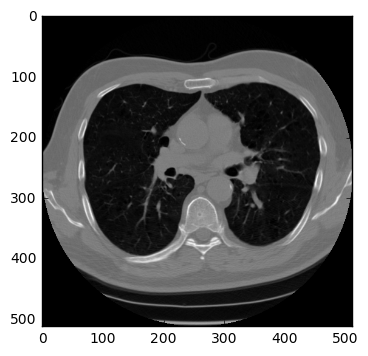

2017-02-18 21:42:40.377835 > [started] resample...


In [ ]:
print('==== PROCESSING SHARD ' + str(SHARD_ID) + ' ====')
start_processing(INPUT_FOLDER, SHARD_ID, 99, IMAGE_W, IMAGE_H, IMAGE_D, OUTPUT_FOLDER)
print('==== ALL DONE ====')